# 외국인(단기 / 장기) 데이터 전처리 및 인구 비율 계산

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

long_foreigner_df = pd.read_csv('data/LONG_FOREIGNER_GU_2023/LONG_FOREIGNER_GU_2023.csv', encoding='euc-kr')
long_foreigner_df.head()

,기준일ID,시간대구분,자치구코드,총생활인구수,중국인체류인구수,중국외외국인체류인구수
0,20230101,0,11110,17123.7269,10726.3427,6397.3860
1,20230101,0,11140,16340.4211,9701.9279,6638.4917
2,20230101,0,11170,17011.2492,3726.0140,13285.2347
3,20230101,0,11200,14816.9678,9885.8209,4931.1422
4,20230101,0,11215,25376.0784,18988.2545,6387.8248


In [3]:
filtered_df = long_foreigner_df[(long_foreigner_df['기준일ID'] == 20231231) & (long_foreigner_df['시간대구분'] == 0)].copy()

In [4]:
filtered_df = filtered_df.reset_index(drop=True)

In [5]:
guCode = pd.read_csv('data/guCode.csv', encoding='utf-8')
guCode.head()

,구명,코드
0,종로구,11110
1,중구,11140
2,용산구,11170
3,성동구,11200
4,광진구,11215


In [6]:
# guCode를 읽어 자치구코드 -> 구명 딕셔너리 생성
# make sure we operate on a copy to avoid SettingWithCopyWarning
filtered_df = filtered_df.copy()

guCode = pd.read_csv('data/guCode.csv', encoding='utf-8')
gu_code_dict = dict(zip(guCode['코드'].astype(int), guCode['구명']))

# 자치구코드 타입 정리 및 매핑
filtered_df['자치구코드'] = filtered_df['자치구코드'].astype(int)
filtered_df['자치구'] = filtered_df['자치구코드'].map(gu_code_dict)

# 결과 확인
filtered_df.head()

,기준일ID,시간대구분,자치구코드,총생활인구수,중국인체류인구수,중국외외국인체류인구수,자치구
0,20231231,0,11110,13640.1804,8670.2565,4969.9249,종로구
1,20231231,0,11140,13589.2959,8190.1204,5399.1757,중구
2,20231231,0,11170,15046.6725,3550.1655,11496.5039,용산구
3,20231231,0,11200,13575.1242,8884.3471,4690.7802,성동구
4,20231231,0,11215,24158.1353,17671.3149,6486.8186,광진구


In [7]:
df = filtered_df[['자치구','총생활인구수','중국인체류인구수','중국외외국인체류인구수']].copy()
df.head()

,자치구,총생활인구수,중국인체류인구수,중국외외국인체류인구수
0,종로구,13640.1804,8670.2565,4969.9249
1,중구,13589.2959,8190.1204,5399.1757
2,용산구,15046.6725,3550.1655,11496.5039
3,성동구,13575.1242,8884.3471,4690.7802
4,광진구,24158.1353,17671.3149,6486.8186


In [8]:
import os

# 결과 디렉터리 확인
os.makedirs('filtered_data', exist_ok=True)

# 기존 df에서 필요한 컬럼 복사
df = df.copy()

# 비율 계산 (백분율)
df['중국인_비율(%)'] = (df['중국인체류인구수'] / df['총생활인구수'] * 100).round(2)
df['중국외_외국인_비율(%)'] = (df['중국외외국인체류인구수'] / df['총생활인구수'] * 100).round(2)

# 출력용 데이터프레임 정리
result_df = df[['자치구', '총생활인구수', '중국인체류인구수', '중국인_비율(%)', 
                '중국외외국인체류인구수', '중국외_외국인_비율(%)']].copy()

# CSV 저장
result_df.to_csv('filtered_data/long_foreigner_ratio_byGu.csv', index=False, encoding='utf-8')

# 결과 확인
result_df.head()

,자치구,총생활인구수,중국인체류인구수,중국인_비율(%),중국외외국인체류인구수,중국외_외국인_비율(%)
0,종로구,13640.1804,8670.2565,63.56,4969.9249,36.44
1,중구,13589.2959,8190.1204,60.27,5399.1757,39.73
2,용산구,15046.6725,3550.1655,23.59,11496.5039,76.41
3,성동구,13575.1242,8884.3471,65.45,4690.7802,34.55
4,광진구,24158.1353,17671.3149,73.15,6486.8186,26.85


In [9]:
# 합계(한국인+외국인) 계산: 지역 기존 총생활인구수(Gu_Populations) + 외국인 총생활인구수(현재 df)
# Gu_Populations.csv 불러오기 및 병합
import os

gu_pop = pd.read_csv('filtered_data/Gu_Populations.csv', encoding='utf-8')
gu_pop = gu_pop.rename(columns={'구명': '자치구', '총생활인구수': '지역총생활인구수'})

# summary_df는 이전에 생성된 요약(외국인 관련) 데이터프레임입니다.
# 만약 summary_df가 존재하지 않으면 result_df를 대신 사용
try:
    src = summary_df.copy()
except NameError:
    src = result_df.copy()

# 원래 src의 '총생활인구수'는 외국인 총생활인구수(질문자 설명)임 -> 명확히 컬럼명 변경
if '총생활인구수' in src.columns:
    src = src.rename(columns={'총생활인구수': '외국인_총생활인구수'})

# 병합
merged = gu_pop.merge(src, on='자치구', how='left')

# 여러 변형의 컬럼명을 허용하여 '중국외외국인체류인구수' 컬럼 확보 (안전하게 처리)
candidate_cols = ['중국외외국인체류인구수', '중국외_외국인체류인구수', '중국외외국인', '중국외_외국인_체류인구수']
for c in candidate_cols:
    if c in merged.columns:
        merged['중국외외국인체류인구수'] = pd.to_numeric(merged[c], errors='coerce').fillna(0)
        break
else:
    merged['중국외외국인체류인구수'] = 0

# 안전한 결측 처리: 주요 수치 컬럼들을 숫자로 변환 후 결측을 0으로 채움
for col in ['외국인_총생활인구수', '중국인체류인구수', '중국외외국인체류인구수', '총외국인수']:
    if col in merged.columns:
        merged[col] = pd.to_numeric(merged[col], errors='coerce').fillna(0)
    else:
        merged[col] = 0

# 총외국인수가 아직 0이면 중국인+중국외 합으로 채우기
if merged['총외국인수'].eq(0).all():
    merged['총외국인수'] = merged['중국인체류인구수'] + merged['중국외외국인체류인구수']

# 합계(한국인+외국인) 계산
merged['합계_총생활인구수'] = (merged['지역총생활인구수'].fillna(0) + merged['외국인_총생활인구수']).round(2)

# 비율 계산 (안전하게 계산)
merged['외국인_비율(합계대비, %)'] = np.where(merged['합계_총생활인구수']>0,
                                           (merged['외국인_총생활인구수'] / merged['합계_총생활인구수'] * 100).round(2),
                                           np.nan)
merged['중국인_비율(합계대비, %)'] = np.where(merged['합계_총생활인구수']>0,
                                           (merged['중국인체류인구수'] / merged['합계_총생활인구수'] * 100).round(2),
                                           np.nan)
merged['중국인_비율(외국인대비, %)'] = np.where(merged['총외국인수']>0,
                                           (merged['중국인체류인구수'] / merged['총외국인수'] * 100).round(2),
                                           np.nan)

# 저장
os.makedirs('filtered_data', exist_ok=True)
merged.to_csv('filtered_data/foreigner_summary_combined_byGu.csv', index=False, encoding='utf-8')

# 출력 (상위 30)
out = merged[['자치구','지역총생활인구수','외국인_총생활인구수','합계_총생활인구수',
        '외국인_비율(합계대비, %)','중국인체류인구수','중국인_비율(합계대비, %)','중국인_비율(외국인대비, %)']]

out = out.sort_values('합계_총생활인구수', ascending=False).reset_index(drop=True).head(30)
out

,자치구,지역총생활인구수,외국인_총생활인구수,합계_총생활인구수,"외국인_비율(합계대비, %)",중국인체류인구수,"중국인_비율(합계대비, %)","중국인_비율(외국인대비, %)"
0,송파구,736216.399988,12055.4533,748271.85,1.61,7237.4104,0.97,60.03
1,강남구,655545.114288,12317.4010,667862.52,1.84,4364.9508,0.65,35.44
2,강서구,526891.403000,8994.6336,535886.04,1.68,5981.0202,1.12,66.50
3,강동구,509888.837375,8995.2846,518884.12,1.73,6436.9992,1.24,71.56
4,노원구,495216.339754,5255.8342,500472.17,1.05,2267.4867,0.45,43.14
5,영등포구,432745.775954,47207.5466,479953.32,9.84,43914.7663,9.15,93.02
6,서초구,465975.182704,8779.7136,474754.90,1.85,3351.6497,0.71,38.17
7,관악구,450404.012013,22747.9824,473151.99,4.81,15601.1757,3.30,68.58
8,은평구,441263.649617,6072.2302,447335.88,1.36,3395.4339,0.76,55.92
9,마포구,417052.968704,18865.5686,435918.54,4.33,8861.6050,2.03,46.97


# 단기 계산

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

short_foreigner_df = pd.read_csv('data/TEMP_FOREIGNER_GU_2023/TEMP_FOREIGNER_GU_2023.csv', encoding='euc-kr')
short_foreigner_df.head()



,기준일ID,시간대구분,자치구코드,총생활인구수,중국인체류인구수,중국외외국인체류인구수
0,20230101,0,11110,13947.2242,3620.3987,10326.8258
1,20230101,0,11140,39068.4434,8539.6498,30528.7942
2,20230101,0,11170,10946.3983,1854.0081,9092.3911
3,20230101,0,11200,2145.8360,913.8429,1231.9949
4,20230101,0,11215,3249.3079,1788.7691,1460.5397


In [11]:
filtered_df = short_foreigner_df[(short_foreigner_df['기준일ID'] == 20231231) & (short_foreigner_df['시간대구분'] == 0)].copy()

In [12]:
filtered_df = filtered_df.reset_index(drop=True)

In [13]:
guCode = pd.read_csv('data/guCode.csv', encoding='utf-8')
guCode.head()

,구명,코드
0,종로구,11110
1,중구,11140
2,용산구,11170
3,성동구,11200
4,광진구,11215


In [14]:
# guCode를 읽어 자치구코드 -> 구명 딕셔너리 생성
guCode = pd.read_csv('data/guCode.csv', encoding='utf-8')
gu_code_dict = dict(zip(guCode['코드'].astype(int), guCode['구명']))

# 자치구코드 타입 정리 및 매핑
filtered_df['자치구코드'] = filtered_df['자치구코드'].astype(int)
filtered_df['자치구'] = filtered_df['자치구코드'].map(gu_code_dict)

# 결과 확인
filtered_df.head()

,기준일ID,시간대구분,자치구코드,총생활인구수,중국인체류인구수,중국외외국인체류인구수,자치구
0,20231231,0,11110,18084.8472,7326.0274,10758.8196,종로구
1,20231231,0,11140,49038.8490,16708.3318,32330.5164,중구
2,20231231,0,11170,13752.6183,4486.1587,9266.4575,용산구
3,20231231,0,11200,2385.1390,988.6011,1396.5399,성동구
4,20231231,0,11215,2711.0784,1307.7645,1403.3135,광진구


In [15]:
df = filtered_df[['자치구','총생활인구수','중국인체류인구수','중국외외국인체류인구수']].copy()
df.head()

,자치구,총생활인구수,중국인체류인구수,중국외외국인체류인구수
0,종로구,18084.8472,7326.0274,10758.8196
1,중구,49038.8490,16708.3318,32330.5164
2,용산구,13752.6183,4486.1587,9266.4575
3,성동구,2385.1390,988.6011,1396.5399
4,광진구,2711.0784,1307.7645,1403.3135


In [16]:
import os

# 결과 디렉터리 확인
os.makedirs('filtered_data', exist_ok=True)

# 기존 df에서 필요한 컬럼 복사
df = df.copy()

# 비율 계산 (백분율)
df['중국인_비율(%)'] = (df['중국인체류인구수'] / df['총생활인구수'] * 100).round(2)
df['중국외_외국인_비율(%)'] = (df['중국외외국인체류인구수'] / df['총생활인구수'] * 100).round(2)

# 출력용 데이터프레임 정리
result_df = df[['자치구', '총생활인구수', '중국인체류인구수', '중국인_비율(%)', 
                '중국외외국인체류인구수', '중국외_외국인_비율(%)']].copy()

# CSV 저장
result_df.to_csv('filtered_data/temp_foreigner_ratio_byGu.csv', index=False, encoding='utf-8')

# 결과 확인
result_df.head()

,자치구,총생활인구수,중국인체류인구수,중국인_비율(%),중국외외국인체류인구수,중국외_외국인_비율(%)
0,종로구,18084.8472,7326.0274,40.51,10758.8196,59.49
1,중구,49038.8490,16708.3318,34.07,32330.5164,65.93
2,용산구,13752.6183,4486.1587,32.62,9266.4575,67.38
3,성동구,2385.1390,988.6011,41.45,1396.5399,58.55
4,광진구,2711.0784,1307.7645,48.24,1403.3135,51.76


In [17]:
# 합계(한국인+외국인) 계산: 지역 기존 총생활인구수(Gu_Populations) + 외국인 총생활인구수(현재 df)
# Gu_Populations.csv 불러오기 및 병합
gu_pop = pd.read_csv('filtered_data/Gu_Populations.csv', encoding='utf-8')
gu_pop = gu_pop.rename(columns={'구명': '자치구', '총생활인구수': '지역총생활인구수'})

# summary_df는 이전에 생성된 요약(외국인 관련) 데이터프레임입니다.
# 만약 summary_df가 존재하지 않으면 result_df를 대신 사용
try:
    src = summary_df.copy()
except NameError:
    src = result_df.copy()

# 원래 src의 '총생활인구수'는 외국인 총생활인구수(질문자 설명)임 -> 명확히 컬럼명 변경
if '총생활인구수' in src.columns:
    src = src.rename(columns={'총생활인구수': '외국인_총생활인구수'})

# 병합
merged = gu_pop.merge(src, on='자치구', how='left')

# 여러 변형의 컬럼명을 허용하여 '중국외외국인체류인구수' 컬럼 확보
candidate_cols = ['중국외외국인체류인구수', '중국외_외국인체류인구수', '중국외외국인', '중국외_외국인_체류인구수']
found = False
for c in candidate_cols:
    if c in merged.columns:
        merged['중국외외국인체류인구수'] = merged[c]
        found = True
        break
if not found:
    merged['중국외외국인체류인구수'] = 0

# 안전한 결측 처리
for col in ['외국인_총생활인구수', '중국인체류인구수', '중국외외국인체류인구수', '총외국인수']:
    if col in merged.columns:
        merged[col] = merged[col].fillna(0)

# 총외국인수가 없으면 중국인+중국외 합으로 채우기
if '총외국인수' not in merged.columns:
    merged['총외국인수'] = merged['중국인체류in구수'] if '중국인체류in구수' in merged.columns else 0
# try to compute if zeros
merged['총외국인수'] = merged.get('총외국인수', 0)
merged['총외국인수'] = merged['총외국인수'].replace({0: np.nan})
merged['총외국인수'] = merged['총외국인수'].fillna(merged['중국인체류인구수'] + merged['중국외외국인체류인구수'])

# 합계(한국인+외국인) 계산
merged['합계_총생활인구수'] = (merged['지역총생활인구수'] + merged['외국인_총생활인구수']).round(2)

# 비율 계산 (안전하게 계산)
merged['외국인_비율(합계대비, %)'] = np.where(merged['합계_총생활인구수']>0,
                                           (merged['외국인_총생활인구수'] / merged['합계_총생활인구수'] * 100).round(2),
                                           np.nan)
merged['중국인_비율(합계대비, %)'] = np.where(merged['합계_총생활인구수']>0,
                                           (merged['중국인체류인구수'] / merged['합계_총생활인구수'] * 100).round(2),
                                           np.nan)
merged['중국인_비율(외국인대비, %)'] = np.where(merged['총외국인수']>0,
                                           (merged['중국인체류인구수'] / merged['총외국인수'] * 100).round(2),
                                           np.nan)

# 저장
os.makedirs('filtered_data', exist_ok=True)
merged.to_csv('filtered_data/temp_foreigner_summary_combined_byGu.csv', index=False, encoding='utf-8')

# 출력 (상위 30)
out = merged[['자치구','지역총생활인구수','외국인_총생활인구수','합계_총생활인구수',
        '외국인_비율(합계대비, %)','중국인체류인구수','중국인_비율(합계대비, %)','중국인_비율(외국인대비, %)']]

out = out.sort_values('합계_총생활인구수', ascending=False).reset_index(drop=True).head(30)
out

,자치구,지역총생활인구수,외국인_총생활인구수,합계_총생활인구수,"외국인_비율(합계대비, %)",중국인체류인구수,"중국인_비율(합계대비, %)","중국인_비율(외국인대비, %)"
0,송파구,736216.399988,5428.7587,741645.16,0.73,1454.6294,0.20,26.79
1,강남구,655545.114288,23423.6723,678968.79,3.45,8834.3422,1.30,37.72
2,강서구,526891.403000,8028.5767,534919.98,1.50,2916.0488,0.55,36.32
3,강동구,509888.837375,1328.7691,511217.61,0.26,355.3613,0.07,26.74
4,노원구,495216.339754,655.8997,495872.24,0.13,85.2076,0.02,12.99
5,서초구,465975.182704,8161.8950,474137.08,1.72,2256.7136,0.48,27.65
6,관악구,450404.012013,2044.2641,452448.28,0.45,1152.1261,0.25,56.36
7,마포구,417052.968704,27331.4493,444384.42,6.15,12104.6955,2.72,44.29
8,영등포구,432745.775954,10550.2189,443295.99,2.38,6558.0905,1.48,62.16
9,은평구,441263.649617,1277.7924,442541.44,0.29,261.9594,0.06,20.50


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress benign pandas chained-assignment warnings and reduce noisy warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

In [19]:
korean_df = pd.read_csv('filtered_data/Gu_Populations.csv', encoding='utf-8')
long_foreig_df = pd.read_csv('filtered_data/long_foreigner_ratio_byGu.csv', encoding='utf-8')
temp_foreig_df = pd.read_csv('filtered_data/temp_foreigner_ratio_byGu.csv', encoding='utf-8')

In [20]:
added_df.to_csv('filtered_data/sum_foregn_data.csv', encoding='utf-8')

NameError: name 'added_df' is not defined

In [22]:
added_df = pd.read_csv('filtered_data/sum_foregn_data.csv', encoding='utf-8')

In [23]:
korean_df.rename(columns={'구명':'자치구'}, inplace=True)

In [24]:
population_df = pd.merge(korean_df, added_df, on='자치구', how='inner')
population_df.head()

,자치구,index,기준일ID,총생활인구수,Unnamed: 0,외국인생활인구수
0,강남구,218709.5,20231231.0,655545.114288,0,35741.0733
1,강동구,218711.5,20231231.0,509888.837375,1,10324.0537
2,강북구,218695.5,20231231.0,287913.541725,2,8029.4181
3,강서구,218702.5,20231231.0,526891.403000,3,17023.2103
4,관악구,218707.5,20231231.0,450404.012013,4,24792.2465


In [25]:
population_df.drop(columns=['Unnamed: 0'], inplace=True)


In [26]:
population_df.rename(columns={'총생활인구수':'내국인생활인구수'}, inplace=True)

In [27]:
population_df['총생활인구수'] = population_df['내국인생활인구수'] + population_df['외국인생활인구수']
population_df.head()

,자치구,index,기준일ID,내국인생활인구수,외국인생활인구수,총생활인구수
0,강남구,218709.5,20231231.0,655545.114288,35741.0733,691286.187588
1,강동구,218711.5,20231231.0,509888.837375,10324.0537,520212.891075
2,강북구,218695.5,20231231.0,287913.541725,8029.4181,295942.959825
3,강서구,218702.5,20231231.0,526891.403000,17023.2103,543914.613300
4,관악구,218707.5,20231231.0,450404.012013,24792.2465,475196.258513


In [28]:
percent = pd.DataFrame()

In [29]:
percent['자치구'] = population_df['자치구'].copy()

In [30]:
percent['내국인_비율'] = population_df['내국인생활인구수']/population_df['총생활인구수'] * 100

In [31]:
percent['외국인_비율'] = population_df['외국인생활인구수']/population_df['총생활인구수'] * 100

In [32]:
percent.head()

,자치구,내국인_비율,외국인_비율
0,강남구,94.829772,5.170228
1,강동구,98.015418,1.984582
2,강북구,97.286836,2.713164
3,강서구,96.870242,3.129758
4,관악구,94.782735,5.217265


<Axes: >

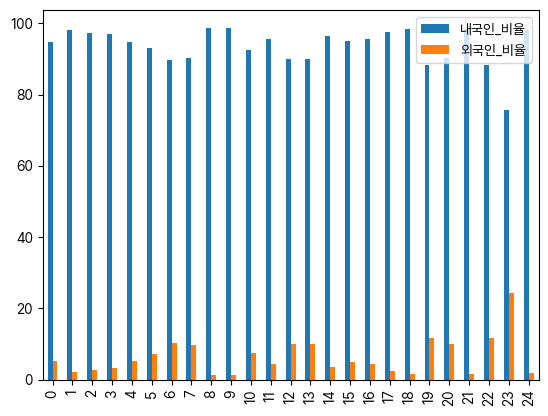

In [33]:
percent.plot.bar()

In [34]:
percent.to_csv('./filtered_data/gu_foreig_pct.csv', encoding = 'utf-8')

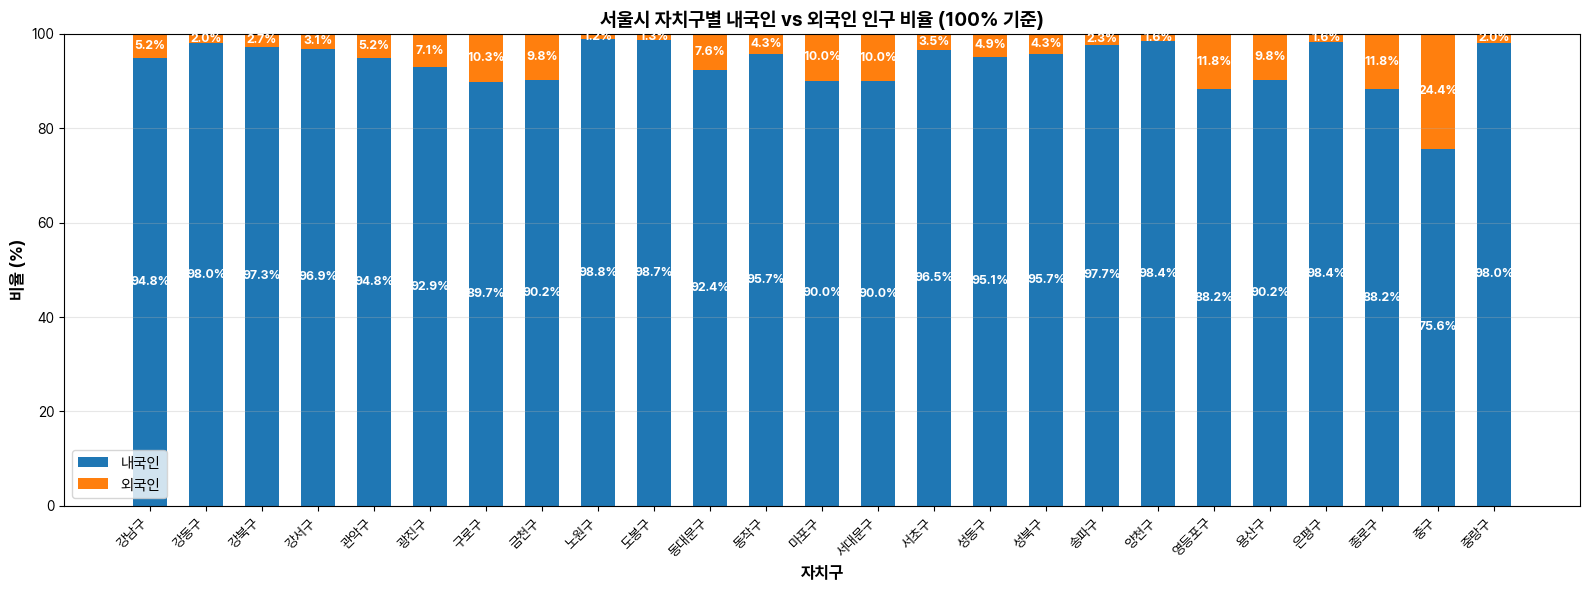

In [35]:
# 100% 기준 수직 막대 그래프
fig, ax = plt.subplots(figsize=(16, 6))

# 데이터 준비
x_pos = np.arange(len(percent))
width = 0.6

# 스택 바 차트
ax.bar(x_pos, percent['내국인_비율'], width, label='내국인', color='#1f77b4')
ax.bar(x_pos, percent['외국인_비율'], width, 
       bottom=percent['내국인_비율'], label='외국인', color='#ff7f0e')

# 레이블 및 제목
ax.set_xlabel('자치구', fontsize=12, fontweight='bold')
ax.set_ylabel('비율 (%)', fontsize=12, fontweight='bold')
ax.set_title('서울시 자치구별 내국인 vs 외국인 인구 비율 (100% 기준)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(percent['자치구'], rotation=45, ha='right')
ax.set_ylim(0, 100)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# 각 구에 비율 값 표시
for i, (korean, foreign) in enumerate(zip(percent['내국인_비율'], percent['외국인_비율'])):
    ax.text(i, korean/2, f'{korean:.1f}%', ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    ax.text(i, korean + foreign/2, f'{foreign:.1f}%', ha='center', va='center', fontsize=9, fontweight='bold', color='white')

plt.tight_layout()
plt.show()


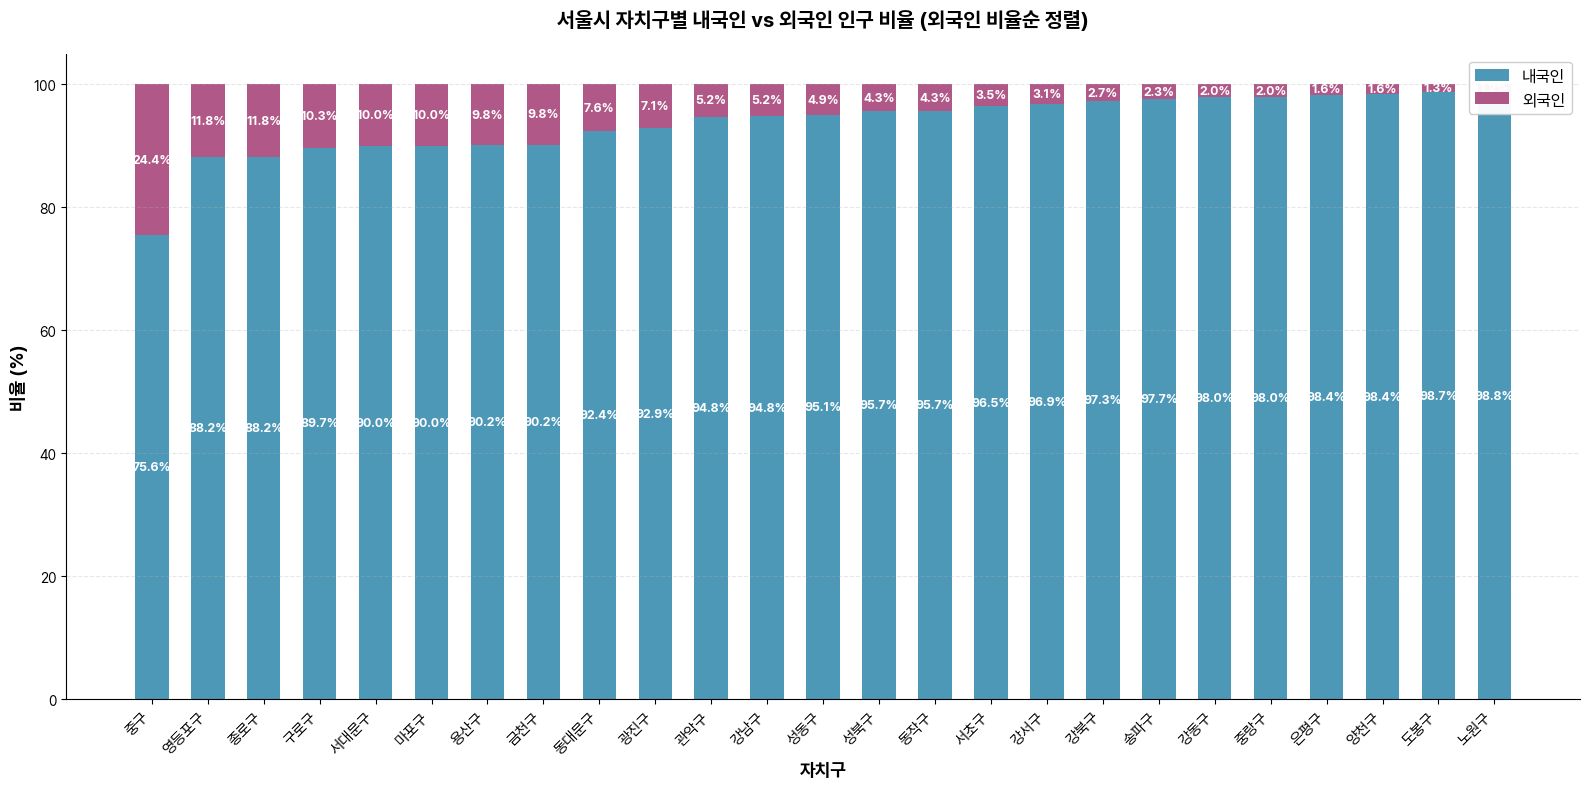

,자치구,내국인_비율,외국인_비율
0,중구,75.581708,24.418292
1,영등포구,88.224802,11.775198
2,종로구,88.246945,11.753055
3,구로구,89.734766,10.265234
4,서대문구,89.961469,10.038531
5,마포구,90.027627,9.972373
6,용산구,90.159867,9.840133
7,금천구,90.234725,9.765275
8,동대문구,92.437777,7.562223
9,광진구,92.936322,7.063678


In [36]:
# 외국인 비율이 높은 순으로 정렬
percent_sorted = percent.sort_values('외국인_비율', ascending=False).reset_index(drop=True)

# Seaborn을 사용한 시각화
fig, ax = plt.subplots(figsize=(16, 8))

# 데이터 준비
x_pos = np.arange(len(percent_sorted))
width = 0.6

# 스택 바 차트
sns.set_palette("husl")
bars1 = ax.bar(x_pos, percent_sorted['내국인_비율'], width, label='내국인', color='#2E86AB', alpha=0.85)
bars2 = ax.bar(x_pos, percent_sorted['외국인_비율'], width, 
               bottom=percent_sorted['내국인_비율'], label='외국인', color='#A23B72', alpha=0.85)

# 레이블 및 제목
ax.set_xlabel('자치구', fontsize=13, fontweight='bold')
ax.set_ylabel('비율 (%)', fontsize=13, fontweight='bold')
ax.set_title('서울시 자치구별 내국인 vs 외국인 인구 비율 (외국인 비율순 정렬)', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(percent_sorted['자치구'], rotation=45, ha='right', fontsize=11)
ax.set_ylim(0, 105)
ax.legend(fontsize=12, loc='upper right', framealpha=0.95)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# 각 구에 비율 값 표시
for i, (korean, foreign) in enumerate(zip(percent_sorted['내국인_비율'], percent_sorted['외국인_비율'])):
    ax.text(i, korean/2, f'{korean:.1f}%', ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    ax.text(i, korean + foreign/2, f'{foreign:.1f}%', ha='center', va='center', fontsize=9, fontweight='bold', color='white')

# 배경 스타일
sns.despine(left=False, bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('results/자치구별_내외국인_비율.png', dpi=300, bbox_inches='tight')
plt.show()

percent_sorted

In [37]:
gu_fire = pd.read_csv('filtered_data/gu_fire_counts.csv',encoding = 'utf8')

gu_fire.rename(columns={'행정구역':'자치구', '화재_건수': '화재건수'}, inplace = True)

In [38]:
gu_fire.head()

,자치구,화재건수
0,강남구,2093
1,강동구,1051
2,강북구,854
3,강서구,1263
4,관악구,1375


외국인 비율과 화재 건수 상관계수: -0.0495
내국인 비율과 화재 건수 상관계수: 0.0495

외국인 비율 회귀계수: -2.8065
외국인 비율 p-value: 0.814174
내국인 비율 회귀계수: 2.8065
내국인 비율 p-value: 0.814174


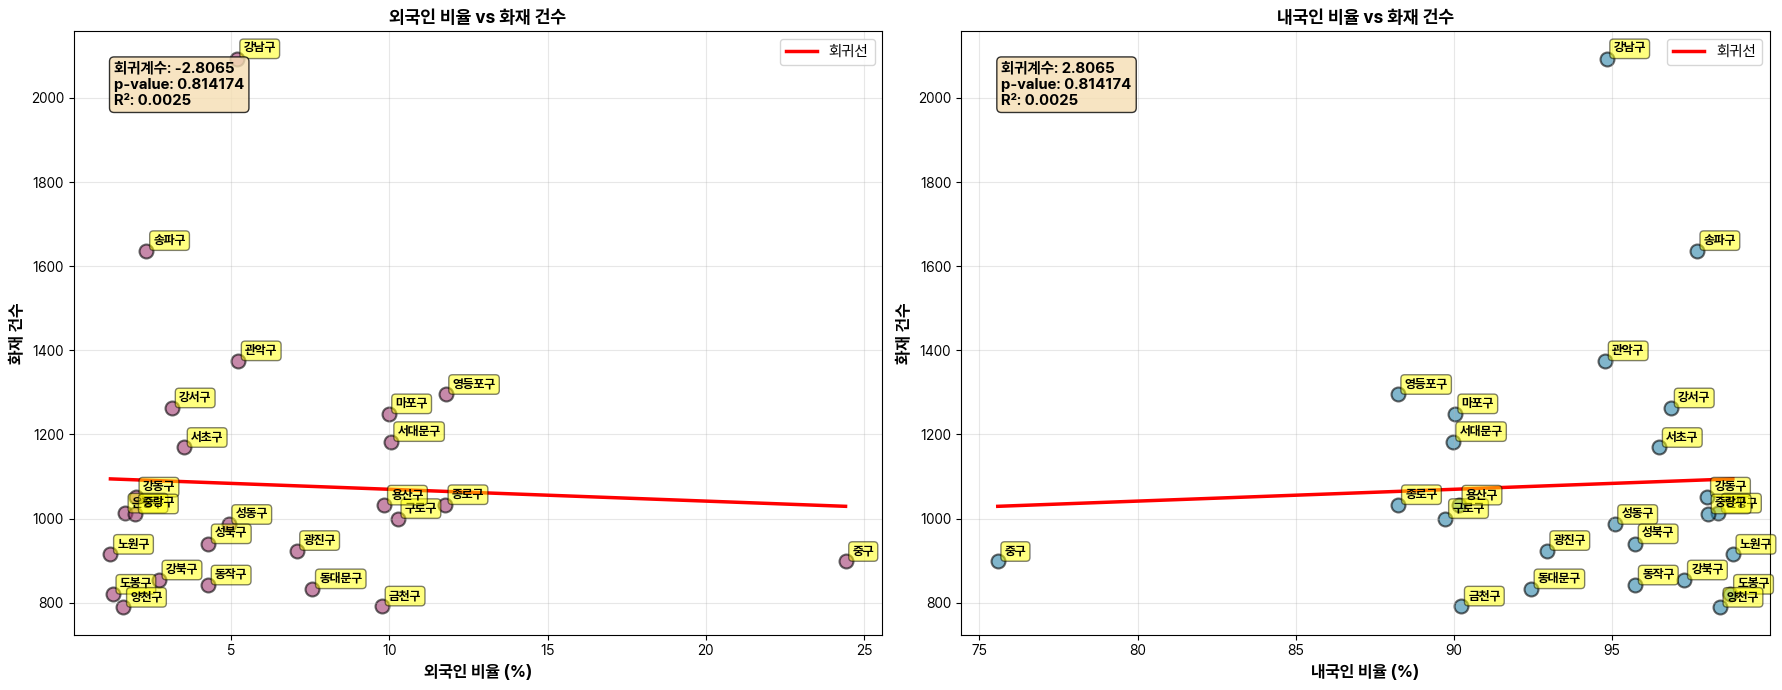


분석 데이터:
     자치구     외국인_비율     내국인_비율  화재건수
0    강남구   5.170228  94.829772  2093
1    강동구   1.984582  98.015418  1051
2    강북구   2.713164  97.286836   854
3    강서구   3.129758  96.870242  1263
4    관악구   5.217265  94.782735  1375
5    광진구   7.063678  92.936322   924
6    구로구  10.265234  89.734766  1000
7    금천구   9.765275  90.234725   792
8    노원구   1.179685  98.820315   915
9    도봉구   1.255876  98.744124   820
10  동대문구   7.562223  92.437777   833
11   동작구   4.266681  95.733319   842
12   마포구   9.972373  90.027627  1249
13  서대문구  10.038531  89.961469  1183
14   서초구   3.508184  96.491816  1169
15   성동구   4.918429  95.081571   986
16   성북구   4.271233  95.728767   940
17   송파구   2.319782  97.680218  1637
18   양천구   1.589514  98.410486   789
19  영등포구  11.775198  88.224802  1295
20   용산구   9.840133  90.159867  1032
21   은평구   1.638386  98.361614  1013
22   종로구  11.753055  88.246945  1033
23    중구  24.418292  75.581708   898
24   중랑구   1.964998  98.035002  1011


In [39]:
from scipy import stats

# percent와 gu_fire 데이터 병합
analysis_df = percent.merge(gu_fire, on='자치구', how='inner')

# 외국인 비율과 화재 건수의 상관관계 분석
correlation_foreign = analysis_df['외국인_비율'].corr(analysis_df['화재건수'])
# 내국인 비율과 화재 건수의 상관관계 분석
correlation_korean = analysis_df['내국인_비율'].corr(analysis_df['화재건수'])

print(f"외국인 비율과 화재 건수 상관계수: {correlation_foreign:.4f}")
print(f"내국인 비율과 화재 건수 상관계수: {correlation_korean:.4f}")

# 선형 회귀 분석 (외국인 비율)
slope_foreign, intercept_foreign, r_value_foreign, p_value_foreign, std_err_foreign = stats.linregress(analysis_df['외국인_비율'], analysis_df['화재건수'])
# 선형 회귀 분석 (내국인 비율)
slope_korean, intercept_korean, r_value_korean, p_value_korean, std_err_korean = stats.linregress(analysis_df['내국인_비율'], analysis_df['화재건수'])

print(f"\n외국인 비율 회귀계수: {slope_foreign:.4f}")
print(f"외국인 비율 p-value: {p_value_foreign:.6f}")
print(f"내국인 비율 회귀계수: {slope_korean:.4f}")
print(f"내국인 비율 p-value: {p_value_korean:.6f}")

# Scatter 그래프 - 외국인 비율과 화재 건수
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 외국인 비율
ax1 = axes[0]
ax1.scatter(analysis_df['외국인_비율'], analysis_df['화재건수'], s=100, alpha=0.6, color='#A23B72', edgecolors='black', linewidth=1.5)

# 구별 이름 표시
for idx, row in analysis_df.iterrows():
    ax1.annotate(row['자치구'], 
                (row['외국인_비율'], row['화재건수']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

# 회귀선 그리기
x_line_foreign = np.linspace(analysis_df['외국인_비율'].min(), analysis_df['외국인_비율'].max(), 100)
y_line_foreign = slope_foreign * x_line_foreign + intercept_foreign
ax1.plot(x_line_foreign, y_line_foreign, 'r-', linewidth=2.5, label='회귀선')

# 텍스트 박스에 회귀계수와 p-value 표시
textstr = f'회귀계수: {slope_foreign:.4f}\np-value: {p_value_foreign:.6f}\nR²: {r_value_foreign**2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=11, verticalalignment='top', bbox=props, fontweight='bold')

ax1.set_xlabel('외국인 비율 (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('화재 건수', fontsize=12, fontweight='bold')
ax1.set_title('외국인 비율 vs 화재 건수', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# 내국인 비율
ax2 = axes[1]
ax2.scatter(analysis_df['내국인_비율'], analysis_df['화재건수'], s=100, alpha=0.6, color='#2E86AB', edgecolors='black', linewidth=1.5)

# 구별 이름 표시
for idx, row in analysis_df.iterrows():
    ax2.annotate(row['자치구'], 
                (row['내국인_비율'], row['화재건수']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

# 회귀선 그리기
x_line_korean = np.linspace(analysis_df['내국인_비율'].min(), analysis_df['내국인_비율'].max(), 100)
y_line_korean = slope_korean * x_line_korean + intercept_korean
ax2.plot(x_line_korean, y_line_korean, 'r-', linewidth=2.5, label='회귀선')

# 텍스트 박스에 회귀계수와 p-value 표시
textstr = f'회귀계수: {slope_korean:.4f}\np-value: {p_value_korean:.6f}\nR²: {r_value_korean**2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=11, verticalalignment='top', bbox=props, fontweight='bold')

ax2.set_xlabel('내국인 비율 (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('화재 건수', fontsize=12, fontweight='bold')
ax2.set_title('내국인 비율 vs 화재 건수', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

plt.tight_layout()
plt.savefig('results/내외국인_비율_화재_상관관계.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n분석 데이터:")
print(analysis_df[['자치구', '외국인_비율', '내국인_비율', '화재건수']])


In [40]:
# --- 구별 화재 건수 집계 (FireData19_23.csv 사용)  
import pandas as pd
import os

# 파일 읽기 (여러 인코딩 시도)
file_path = 'data/FireData19_23.csv'
enc_used = None
for enc in ('utf-8', 'cp949', 'euc-kr'):
    try:
        fire_df = pd.read_csv(file_path, encoding=enc)
        enc_used = enc
        print(f"Loaded {file_path} with encoding: {enc}")
        break
    except Exception as e:
        last_err = e
if enc_used is None:
    raise last_err

# 구 컬럼으로 'SGG_NM' 사용(명시)
if 'SGG_NM' not in fire_df.columns:
    raise ValueError(f"파일에 'SGG_NM' 컬럼이 없습니다. 가능한 컬럼들: {fire_df.columns.tolist()}")

gu_col = 'SGG_NM'
print(f"Using column '{gu_col}' as gu identifier for counting")

# 문자열 정리
fire_df[gu_col] = fire_df[gu_col].astype(str).str.strip()

# 간단한 정규화: 공백 제거 및 통일 (예: '서울특별시 ' 제거)
fire_df[gu_col] = fire_df[gu_col].str.replace('\s+', ' ', regex=True).str.strip()

# 그룹화하여 건수 집계
gu_fire_counts = fire_df.groupby(gu_col).size().reset_index(name='화재건수')
# 컬럼명 통일
gu_fire_counts = gu_fire_counts.rename(columns={gu_col: '자치구'})

# 추가 정규화: '자치구' 칼럼에서 불필요한 접미사 제거(선택적)
# 예: '서울특별시 강남구' -> '강남구' 처리 필요하면 아래 주석을 해제하고 조정
# gu_fire_counts['자치구'] = gu_fire_counts['자치구'].str.replace(r'^서울특별시\s*', '', regex=True)

# 저장
os.makedirs('filtered_data', exist_ok=True)
gu_fire_counts.to_csv('filtered_data/gu_fire_counts.csv', index=False, encoding='utf-8')

# 출력
print('\nTop 20 자치구별 화재건수:')
print(gu_fire_counts.sort_values('화재건수', ascending=False).head(20).to_string(index=False))

gu_fire_counts = gu_fire_counts.sort_values('화재건수', ascending=False).reset_index(drop=True)
gu_fire_counts

Loaded data/FireData19_23.csv with encoding: utf-8
Using column 'SGG_NM' as gu identifier for counting

Top 20 자치구별 화재건수:
 자치구  화재건수
 강남구  2093
 송파구  1637
 관악구  1375
영등포구  1295
 강서구  1263
 마포구  1249
서대문구  1183
 서초구  1169
 강동구  1051
 종로구  1033
 용산구  1032
 은평구  1013
 중랑구  1011
 구로구  1000
 성동구   986
 성북구   940
 광진구   924
 노원구   915
  중구   898
 강북구   854


,자치구,화재건수
0,강남구,2093
1,송파구,1637
2,관악구,1375
3,영등포구,1295
4,강서구,1263
5,마포구,1249
6,서대문구,1183
7,서초구,1169
8,강동구,1051
9,종로구,1033


In [41]:
gu_fire_counts.to_csv('./filtered_data/19_23_gu_fire_counts.csv', encoding = 'utf-8')

외국인 비율과 화재 건수 상관계수: -0.0495
내국인 비율과 화재 건수 상관계수: 0.0495

외국인 비율 회귀계수: -2.8065
외국인 비율 p-value: 0.814174
내국인 비율 회귀계수: 2.8065
내국인 비율 p-value: 0.814174


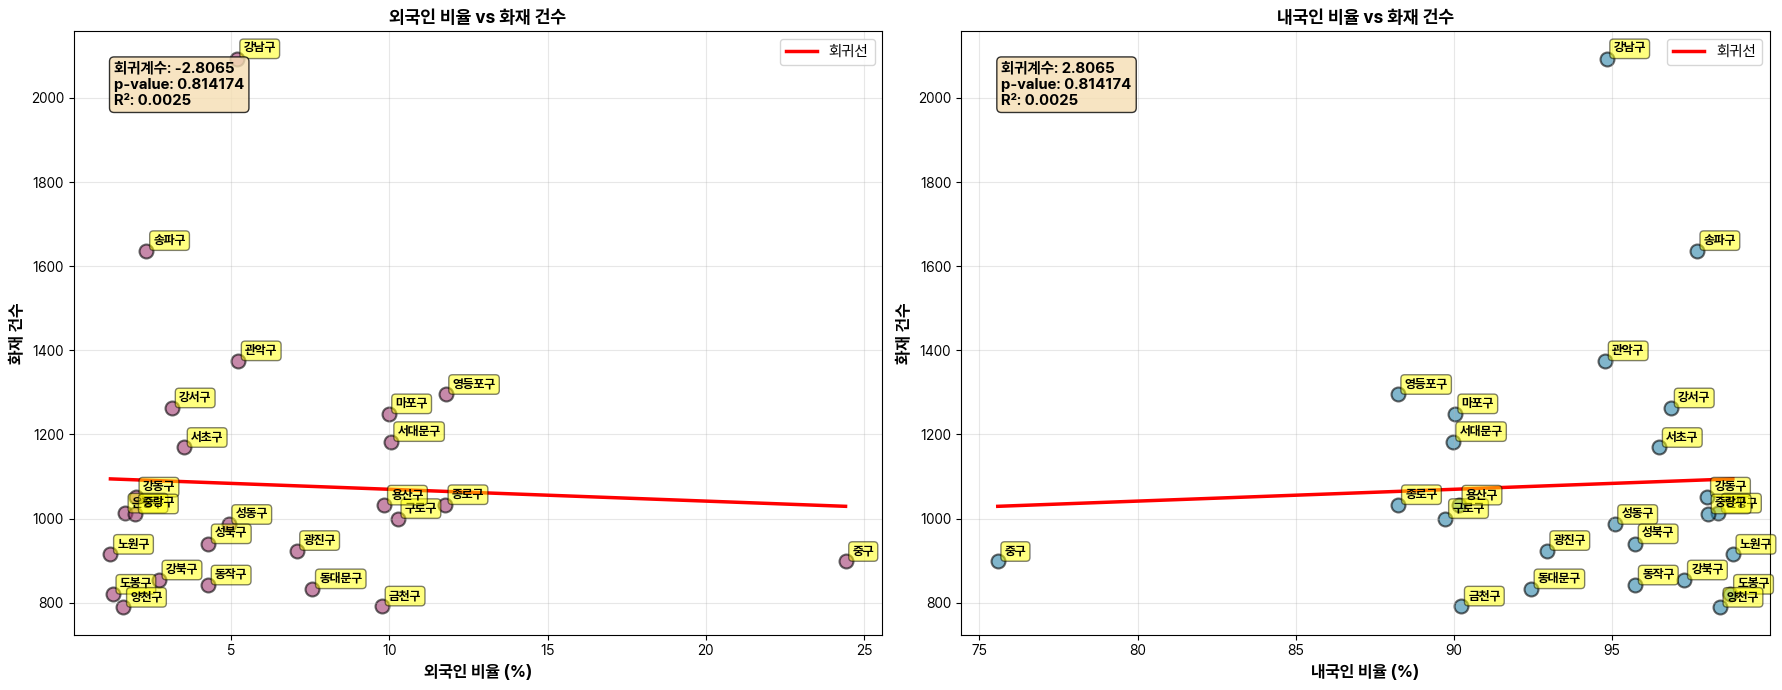


분석 데이터:
     자치구     외국인_비율     내국인_비율  화재건수
0    강남구   5.170228  94.829772  2093
1    강동구   1.984582  98.015418  1051
2    강북구   2.713164  97.286836   854
3    강서구   3.129758  96.870242  1263
4    관악구   5.217265  94.782735  1375
5    광진구   7.063678  92.936322   924
6    구로구  10.265234  89.734766  1000
7    금천구   9.765275  90.234725   792
8    노원구   1.179685  98.820315   915
9    도봉구   1.255876  98.744124   820
10  동대문구   7.562223  92.437777   833
11   동작구   4.266681  95.733319   842
12   마포구   9.972373  90.027627  1249
13  서대문구  10.038531  89.961469  1183
14   서초구   3.508184  96.491816  1169
15   성동구   4.918429  95.081571   986
16   성북구   4.271233  95.728767   940
17   송파구   2.319782  97.680218  1637
18   양천구   1.589514  98.410486   789
19  영등포구  11.775198  88.224802  1295
20   용산구   9.840133  90.159867  1032
21   은평구   1.638386  98.361614  1013
22   종로구  11.753055  88.246945  1033
23    중구  24.418292  75.581708   898
24   중랑구   1.964998  98.035002  1011


In [42]:
from scipy import stats

# percent와 gu_fire 데이터 병합
analysis_df = percent.merge(gu_fire_counts, on='자치구', how='inner')

# 외국인 비율과 화재 건수의 상관관계 분석
correlation_foreign = analysis_df['외국인_비율'].corr(analysis_df['화재건수'])
# 내국인 비율과 화재 건수의 상관관계 분석
correlation_korean = analysis_df['내국인_비율'].corr(analysis_df['화재건수'])

print(f"외국인 비율과 화재 건수 상관계수: {correlation_foreign:.4f}")
print(f"내국인 비율과 화재 건수 상관계수: {correlation_korean:.4f}")

# 선형 회귀 분석 (외국인 비율)
slope_foreign, intercept_foreign, r_value_foreign, p_value_foreign, std_err_foreign = stats.linregress(analysis_df['외국인_비율'], analysis_df['화재건수'])
# 선형 회귀 분석 (내국인 비율)
slope_korean, intercept_korean, r_value_korean, p_value_korean, std_err_korean = stats.linregress(analysis_df['내국인_비율'], analysis_df['화재건수'])

print(f"\n외국인 비율 회귀계수: {slope_foreign:.4f}")
print(f"외국인 비율 p-value: {p_value_foreign:.6f}")
print(f"내국인 비율 회귀계수: {slope_korean:.4f}")
print(f"내국인 비율 p-value: {p_value_korean:.6f}")

# Scatter 그래프 - 외국인 비율과 화재 건수
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 외국인 비율
ax1 = axes[0]
ax1.scatter(analysis_df['외국인_비율'], analysis_df['화재건수'], s=100, alpha=0.6, color='#A23B72', edgecolors='black', linewidth=1.5)

# 구별 이름 표시
for idx, row in analysis_df.iterrows():
    ax1.annotate(row['자치구'], 
                (row['외국인_비율'], row['화재건수']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

# 회귀선 그리기
x_line_foreign = np.linspace(analysis_df['외국인_비율'].min(), analysis_df['외국인_비율'].max(), 100)
y_line_foreign = slope_foreign * x_line_foreign + intercept_foreign
ax1.plot(x_line_foreign, y_line_foreign, 'r-', linewidth=2.5, label='회귀선')

# 텍스트 박스에 회귀계수와 p-value 표시
textstr = f'회귀계수: {slope_foreign:.4f}\np-value: {p_value_foreign:.6f}\nR²: {r_value_foreign**2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=11, verticalalignment='top', bbox=props, fontweight='bold')

ax1.set_xlabel('외국인 비율 (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('화재 건수', fontsize=12, fontweight='bold')
ax1.set_title('외국인 비율 vs 화재 건수', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# 내국인 비율
ax2 = axes[1]
ax2.scatter(analysis_df['내국인_비율'], analysis_df['화재건수'], s=100, alpha=0.6, color='#2E86AB', edgecolors='black', linewidth=1.5)

# 구별 이름 표시
for idx, row in analysis_df.iterrows():
    ax2.annotate(row['자치구'], 
                (row['내국인_비율'], row['화재건수']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

# 회귀선 그리기
x_line_korean = np.linspace(analysis_df['내국인_비율'].min(), analysis_df['내국인_비율'].max(), 100)
y_line_korean = slope_korean * x_line_korean + intercept_korean
ax2.plot(x_line_korean, y_line_korean, 'r-', linewidth=2.5, label='회귀선')

# 텍스트 박스에 회귀계수와 p-value 표시
textstr = f'회귀계수: {slope_korean:.4f}\np-value: {p_value_korean:.6f}\nR²: {r_value_korean**2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=11, verticalalignment='top', bbox=props, fontweight='bold')

ax2.set_xlabel('내국인 비율 (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('화재 건수', fontsize=12, fontweight='bold')
ax2.set_title('내국인 비율 vs 화재 건수', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

plt.tight_layout()
plt.savefig('results/내외국인_비율_화재_상관관계(19-23).png', dpi=300, bbox_inches='tight')
plt.show()

print("\n분석 데이터:")
print(analysis_df[['자치구', '외국인_비율', '내국인_비율', '화재건수']])


In [43]:
fire_pct = pd.read_csv('./filtered_data/gu_build_fire.csv')

In [44]:
gu_fire = fire_pct[['SGG_NM','인구수','화재율(1만명당)']].copy()
gu_fire = gu_fire.rename(columns={'SGG_NM' : '자치구'})
gu_fire.to_csv('./filtered_data/구별_만명당_화재율.csv', encoding = 'utf-8', index=False)
gu_fire.head()

,자치구,인구수,화재율(1만명당)
0,강남구,655545.114288,6.437391
1,강동구,509888.837375,3.353672
2,강북구,287913.541725,6.946530
3,강서구,526891.403000,5.200313
4,관악구,450404.012013,6.238843


Loaded fire-rate from: ./filtered_data/구별_만명당_화재율.csv
Using '자치구' as gu column and '화재율(1만명당)' as rate column
병합된 행 수: 25

외국인_비율 vs 화재율(1만명당) — 상관계수: 0.5580, 회귀계수(slope): 0.1623, p-value: 0.003749, R^2: 0.3114

내국인_비율 vs 화재율(1만명당) — 상관계수: -0.5580, 회귀계수(slope): -0.1623, p-value: 0.003749, R^2: 0.3114


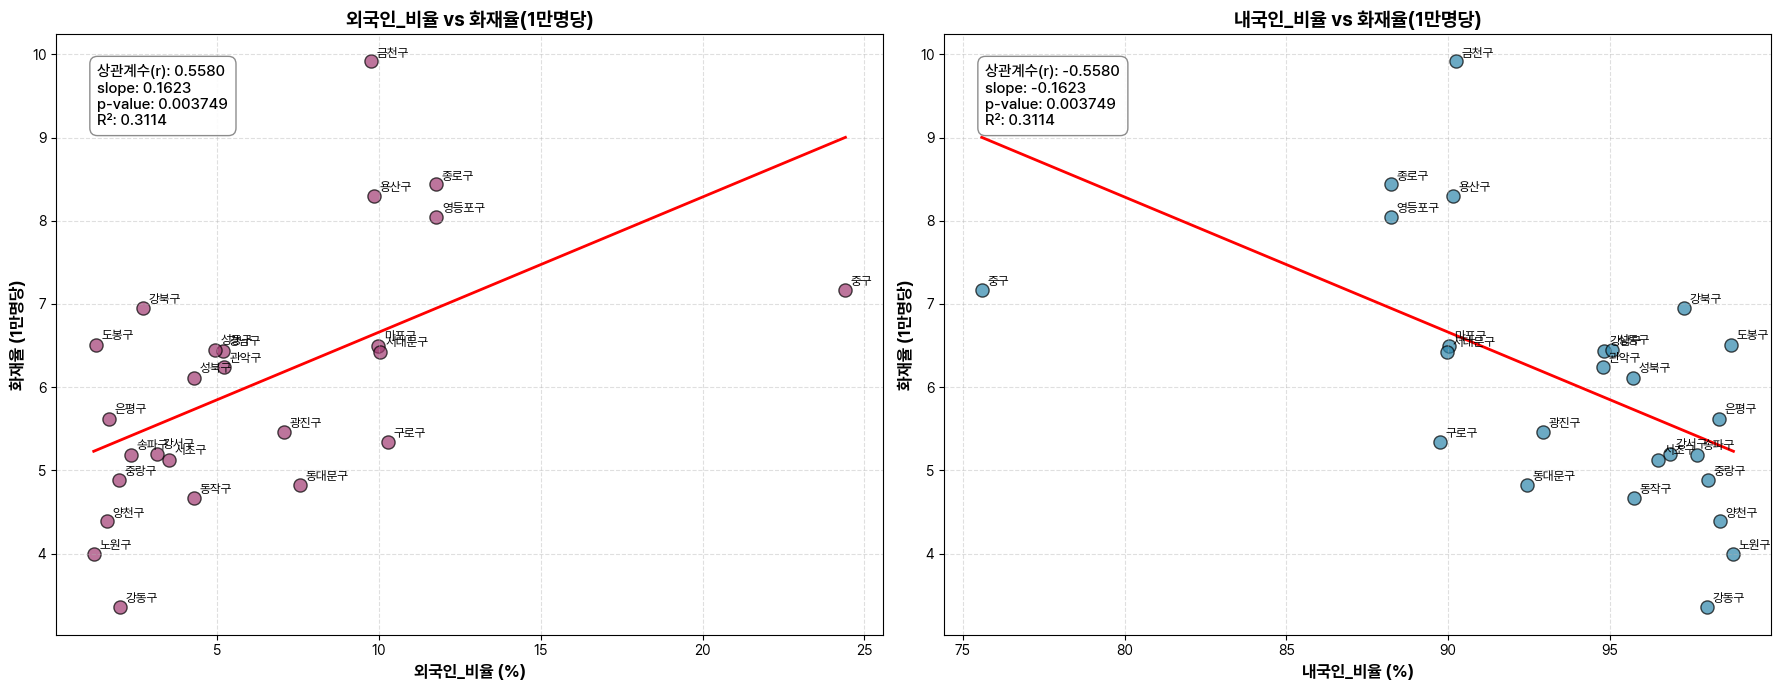

In [45]:
# --- 화재율(1만명당)을 사용한 상관/회귀 분석 (내국인/외국인 비율 vs 화재율)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

# 가능한 파일 목록(우선순위)
candidates = [
    './filtered_data/구별_만명당_화재율.csv',
    './filtered_data/구별_만명당_화재율.csv',
    './filtered_data/gu_build_fire.csv',
    './filtered_data/구별_만명당_화재율.csv',
    './filtered_data/구별_만명당_화재율.csv'
]
fire_rate_df = None
for p in candidates:
    if os.path.exists(p):
        try:
            fire_rate_df = pd.read_csv(p, encoding='utf-8')
            print(f"Loaded fire-rate from: {p}")
            break
        except Exception:
            try:
                fire_rate_df = pd.read_csv(p, encoding='cp949')
                print(f"Loaded fire-rate from: {p} (cp949)")
                break
            except Exception:
                continue

if fire_rate_df is None:
    # 마지막 시도: filtered_data/gu_build_fire.csv if exists
    fallback = './filtered_data/gu_build_fire.csv'
    if os.path.exists(fallback):
        fire_rate_df = pd.read_csv(fallback, encoding='utf-8')
        print(f"Loaded fallback fire-rate from: {fallback}")

if fire_rate_df is None:
    raise FileNotFoundError('화재율 파일을 찾을 수 없습니다. 먼저 `./filtered_data/구별_만명당_화재율.csv` 또는 `./filtered_data/gu_build_fire.csv`를 만들어 주세요.')

# 후보 열 이름 찾기: 자치구와 화재율(1만명당)
cols = fire_rate_df.columns.tolist()
# 자치구 컬럼 후보
gu_candidates = [c for c in cols if any(k in c for k in ['SGG_NM','자치구','구','행정구역','시군구'])]
# 화재율 컬럼 후보
rate_candidates = [c for c in cols if any(k in c for k in ['화재율','1만','만명','화재율(1만명당)','화재율(1만명)'])]

if not gu_candidates:
    raise ValueError(f"자치구 열을 찾을 수 없습니다. 파일 열: {cols}")
if not rate_candidates:
    raise ValueError(f"화재율 열을 찾을 수 없습니다. 파일 열: {cols}")

gu_col = gu_candidates[0]
rate_col = rate_candidates[0]
print(f"Using '{gu_col}' as gu column and '{rate_col}' as rate column")

# 정리
fire_rate_df[gu_col] = fire_rate_df[gu_col].astype(str).str.replace('\s+', ' ', regex=True).str.strip()
# rate 컬럼 숫자로 변환 (콤마 등 처리)
fire_rate_df[rate_col] = fire_rate_df[rate_col].astype(str).str.replace(',', '').str.extract('([0-9\.]+)')[0]
fire_rate_df[rate_col] = pd.to_numeric(fire_rate_df[rate_col], errors='coerce')

# 단순 rename
fire_rate_df = fire_rate_df.rename(columns={gu_col: '자치구', rate_col: '화재율_1만명당'})

# 필요 시: '서울특별시 ' 접두 제거
fire_rate_df['자치구'] = fire_rate_df['자치구'].str.replace(r'^서울특별시\s*', '', regex=True).str.strip()

# 저장 (원본 유지하면서 별도 파일)
os.makedirs('filtered_data', exist_ok=True)
fire_rate_df.to_csv('filtered_data/gu_fire_rate_per10k.csv', index=False, encoding='utf-8')

# percent와 병합
merged_rate_df = percent.merge(fire_rate_df[['자치구','화재율_1만명당']], on='자치구', how='inner')
if merged_rate_df.empty:
    # 시도: 공백 제거를 더 강하게 해서 다시 병합
    percent_tmp = percent.copy()
    percent_tmp['자치구'] = percent_tmp['자치구'].str.replace('\s+', ' ', regex=True).str.strip()
    merged_rate_df = percent_tmp.merge(fire_rate_df[['자치구','화재율_1만명당']], on='자치구', how='inner')

if merged_rate_df.empty:
    print('병합 결과가 비었습니다. `percent`와 fire-rate의 자치구 이름을 확인하세요.')
else:
    print('병합된 행 수:', len(merged_rate_df))

# 상관 및 회귀 (외국인/내국인 비율 vs 화재율_1만명당)
results = {}
for col in ['외국인_비율','내국인_비율']:
    x = merged_rate_df[col]
    y = merged_rate_df['화재율_1만명당']
    corr = x.corr(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    results[col] = dict(corr=corr, slope=slope, intercept=intercept, r_value=r_value, p_value=p_value, std_err=std_err)
    print(f"\n{col} vs 화재율(1만명당) — 상관계수: {corr:.4f}, 회귀계수(slope): {slope:.4f}, p-value: {p_value:.6f}, R^2: {r_value**2:.4f}")

# 시각화
# 시각화 부분 수정
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for ax, col, color in zip(axes, ['외국인_비율','내국인_비율'], ['#A23B72','#2E86AB']):
    # 산점도 그리기
    ax.scatter(merged_rate_df[col], merged_rate_df['화재율_1만명당'], s=90, color=color, alpha=0.7, edgecolors='k')
    
    # 회귀선 계산 및 그리기
    r = results[col]
    x_line = np.linspace(merged_rate_df[col].min(), merged_rate_df[col].max(), 100)
    y_line = r['slope'] * x_line + r['intercept']
    ax.plot(x_line, y_line, 'r-', linewidth=2, label='Regression line')
    
    # 자치구 이름 표시 (Annotation)
    for _, row in merged_rate_df.iterrows():
        ax.annotate(row['자치구'], (row[col], row['화재율_1만명당']), xytext=(4,4), textcoords='offset points', fontsize=9)
    
    # 축 레이블 및 타이틀 설정
    ax.set_xlabel(f"{col} (%)", fontsize=12, fontweight='bold')
    ax.set_ylabel('화재율 (1만명당)', fontsize=12, fontweight='bold')
    ax.set_title(f"{col} vs 화재율(1만명당)", fontsize=14, fontweight='bold')
    
    # --- [수정 포인트] 상관계수 포함 텍스트 상자 ---
    # r['corr']을 추가하여 상관계수를 표시합니다.
    stats_text = (f"상관계수(r): {r['corr']:.4f}\n"
                  f"slope: {r['slope']:.4f}\n"
                  f"p-value: {r['p_value']:.6f}\n"
                  f"R²: {r['r_value']**2:.4f}")
    
    # 텍스트 상자 위치 및 디자인 (왼쪽 상단 배치)
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=11, 
            va='top', fontweight='medium',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round,pad=0.5'))
    
    ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
# 결과 저장 및 출력
plt.savefig('results/내외국인_비율_화재율_상관관계_상관계수포함.png', dpi=300, bbox_inches='tight')
plt.show()